## Remapping BSP in Eulerian coordinates for ECCO outputs in 3D

In [1]:
# Import the MTM function from the WM_Methods package
#from WM_Methods import MTM, Remapping
## Module to track runtime of cells and loops
#import time
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
import dask.array as da

## Load a text file that includes the list of strings pointing to the relevant data. 
## This ensures that pull requests don't continuously overwrite hardcoded file paths.

filename = 'C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/WM_Methods/folders_ECCO.txt'
with open(filename) as f:
    mylist = f.read().splitlines()
    

In [12]:
# Load MTM result

OTMrun='noprior'
yr_init=1992

MTM_result = xr.open_mfdataset(OTMrun+'_transports.nc')

Basins = MTM_result.Basins
tree_depth=int(math.log2(MTM_result.tree_depth))

month_init_early=(MTM_result.init_early-yr_init)*12
month_init_late=(MTM_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+MTM_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+MTM_result.dyrs*12]))


In [13]:
## Load BSP data and calculate fluxes

ECCO_BSP_data = xr.open_mfdataset(('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/tree_depth_6_BSP_ECCO/9_Basins_fluxerr_6/BSP_ECCO_monthly_*'))

## Early Period
Part_early = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
C_early = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')                                 
V_early = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
C_late = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ECCO_BSP_data.Basin.values
# Sections = ACCESS_BSP_data.Section.values

ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
ECCO_dt=ECCO_dt[:,0:ECCO_BSP_data.Time.size,:]

## Calculate the cumulative time integrated surface fluxes 
HFDS_cumsum = ((ECCO_BSP_data.hfds_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
    -((ECCO_BSP_data.hfds_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: J
SFI_cumsum = ((ECCO_BSP_data.sfi_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
     -((ECCO_BSP_data.sfi_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0]))# units: g
WFO_cumsum = ((ECCO_BSP_data.wfo_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
     -((ECCO_BSP_data.wfo_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0]))# units: kg
Cflux_cumsum = ((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                -((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
    
dt_cumsum = ECCO_dt[0,Early_period[0]:Late_period[-1],0].sum() # units: seconds
    
    
## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dsfi = SFI_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dCflux = Cflux_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dt = dt_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

dC_Cflux = dCflux/V_early

dC_Cflux = xr.where(np.isfinite(dC_Cflux),dC_Cflux,0)

In [14]:
## Load masks

chunks = {'Time': 1, 'k': 2, 'tree_depth':1}
chunks2 = {'k': 5, 'Basins': 1}

# Load monthly remapping masks and take time mean over averaging period

#Remapping_mask=xr.open_mfdataset(mylist[24], chunks = chunks).isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

# Load time mean remapping mask

Remapping_mask=xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/WM_Methods/Remapping_mask_ECCO_64.nc', chunks = chunks)

# Load basin mask

ECCO_mask = xr.open_mfdataset(mylist[7] ,decode_times=True, chunks = chunks2).astype('float32')


In [15]:
## Rearrange vector outputs by basin

dC_adj=MTM_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth) # mmol-C/m^3
#dC_mix=MTM_result.dC_mixing.values.reshape(Basins.size,2**tree_depth) # mmol-C/m^3
dC_prior=MTM_result.dC_Cflux.values.reshape(Basins.size,2**tree_depth) # mmol-C/m^3
dC_change = C_late.values - C_early.values # mmol-C/m^3

dC_adj[~np.isfinite(dC_adj)]=0
#dC_mix[~np.isfinite(dC_mix)]=0
dC_prior[~np.isfinite(dC_prior)]=0
dC_change[~np.isfinite(dC_change)]=0


C:\Users\nm455\AppData\Local\Temp\ipykernel_155536\3124744809.py:3: RuntimeWarning: invalid value encountered in divide
  dC_mix=np.matmul(X,MTM_result.gij.values)/V_late.values.flatten() - (C_early.values.flatten()+dC_prior.flatten())


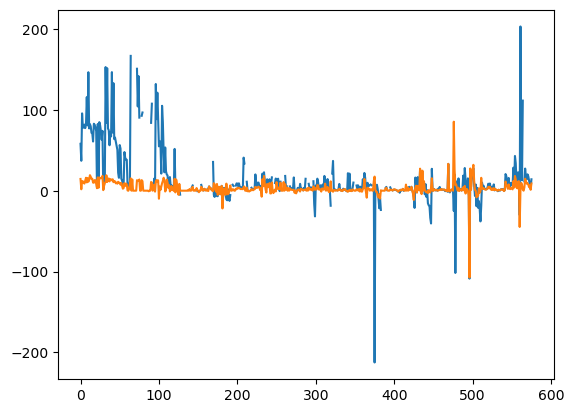

In [16]:
X = C_early.values.flatten()+dC_prior.flatten()
X[np.isnan(X)]=0
dC_mix=np.matmul(X,MTM_result.gij.values)/V_late.values.flatten() - (C_early.values.flatten()+dC_prior.flatten())

plt.plot((dC_prior.flatten()+dC_mix+dC_adj.flatten()))
plt.plot(dC_change.flatten())

dC_mix=dC_mix.reshape(Basins.size,2**tree_depth)

In [17]:
## Allocate values to basins using basin and Eulerian masks

Basin_mask=ECCO_mask.mask_ECCO

dC_adj_tot = 0
dC_mix_tot = 0
dC_prior_tot = 0
dC_Cflux_tot = 0
dC_change_tot = 0

for i in tqdm(range(2**tree_depth)):
    tmp_dCadj = 0
    tmp_dCmix = 0
    tmp_prior = 0
    tmp_dCflux = 0
    tmp_change = 0
    
    for j in range(Basins.size):
        
        tmp = dC_adj[j,i]*Basin_mask[j,:,:,:,:].values * Remapping_mask.Eulerian_mask[i,:,:,:,:].values
        #tmp=tmp.fillna(0)
        tmp=np.nan_to_num(tmp,nan=0)
        tmp_dCadj = tmp+tmp_dCadj
        
        tmp = dC_mix[j,i]*Basin_mask[j,:,:,:,:].values * Remapping_mask.Eulerian_mask[i,:,:,:,:].values
        #tmp=tmp.fillna(0)
        tmp=np.nan_to_num(tmp,nan=0)
        tmp_dCmix = tmp+tmp_dCmix
        
        tmp = dC_prior[j,i]*Basin_mask[j,:,:,:,:].values * Remapping_mask.Eulerian_mask[i,:,:,:,:].values
        #tmp=tmp.fillna(0)
        tmp=np.nan_to_num(tmp,nan=0)
        tmp_prior = tmp+tmp_prior
        
        tmp = dC_Cflux[j,i].values*Basin_mask[j,:,:,:,:].values * Remapping_mask.Eulerian_mask[i,:,:,:,:].values
        tmp=np.nan_to_num(tmp,nan=0)
        tmp_dCflux = tmp+tmp_dCflux
        
        tmp = dC_change[j,i]*Basin_mask[j,:,:,:,:].values * Remapping_mask.Eulerian_mask[i,:,:,:,:].values
        tmp=np.nan_to_num(tmp,nan=0)
        tmp_change = tmp+tmp_change
                                                             
        
    dC_adj_tot = tmp_dCadj+dC_adj_tot
    dC_mix_tot = tmp_dCmix+dC_mix_tot
    dC_prior_tot = tmp_prior+dC_prior_tot
    dC_Cflux_tot = tmp_dCflux+dC_Cflux_tot
    dC_change_tot = tmp_change+dC_change_tot

  0%|          | 0/64 [00:00<?, ?it/s]

C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
## Save remapped outputs to netcdf

da_dC_adj_tot = xr.DataArray(data = dC_adj_tot.astype('float32'), dims = ["k","face","j","i"])
da_dC_mix_tot = xr.DataArray(data = dC_mix_tot.astype('float32'), dims = ["k","face","j","i"])
da_dC_Cflux_tot = xr.DataArray(data = dC_Cflux_tot.astype('float32'), dims = ["k","face","j","i"])
da_dC_prior_tot = xr.DataArray(data = dC_prior_tot.astype('float32'), dims = ["k","face","j","i"])
da_dC_change_tot = xr.DataArray(data = dC_change_tot.astype('float32'), dims = ["k","face","j","i"])

coords=dC_adj[0,0]*Basin_mask[0,:,:,:,:]*Remapping_mask.Eulerian_mask[0,:,:,:,:]

ECCO_MTM_remapped=xr.Dataset(coords=coords.coords).astype('float32')
ECCO_MTM_remapped['dC_adj_remapped'] = da_dC_adj_tot
ECCO_MTM_remapped['dC_mix_remapped'] = da_dC_mix_tot
ECCO_MTM_remapped['dC_Cflux_remapped'] = da_dC_Cflux_tot
ECCO_MTM_remapped['dC_prior_remapped'] = da_dC_prior_tot
ECCO_MTM_remapped['dC_change_remapped'] = da_dC_change_tot
ECCO_MTM_remapped['init_early'] = MTM_result.init_early
ECCO_MTM_remapped['init_late'] = MTM_result.init_late
ECCO_MTM_remapped['dyrs'] = MTM_result.dyrs

ECCO_MTM_remapped.to_netcdf(OTMrun+'_remapped.nc')
#ECCO_MTM_remapped.to_netcdf('OTM_remapped.nc')


In [19]:
print(((ECCO_MTM_remapped.dC_prior_remapped+ECCO_MTM_remapped.dC_adj_remapped)*ECCO_MTM_remapped.drF*ECCO_MTM_remapped.rA).values.sum())
print((ECCO_MTM_remapped.dC_Cflux_remapped*ECCO_MTM_remapped.drF*ECCO_MTM_remapped.rA).values.sum())
print((ECCO_MTM_remapped.dC_adj_remapped*ECCO_MTM_remapped.drF*ECCO_MTM_remapped.rA).values.sum())
print((ECCO_MTM_remapped.dC_change_remapped*ECCO_MTM_remapped.drF*ECCO_MTM_remapped.rA).values.sum())

3.2191988e+18
1.578334e+18
1.6408754e+18
1.7179783e+18
